In this notebook we implement the stage 1 of the phononet architecture in tensorflow. We use the phononet library to just extract the chromogram data.

In [1]:
import matplotlib.pyplot as plt
import json
from collections import Counter

%matplotlib inline

import sys
import os

%load_ext autoreload
%autoreload 2


In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
sys.path.append('../')

In [4]:
import phononet as pn
import utils

In [5]:
include_files = json.load(open('SankalpRagaDataset.json'))  # import list of song_ids to include
cd = pn.FullChromaDataset('hindustaniv2.json', '../../n_ftt4096__hop_length2048',
                          include_mbids=include_files)  # load dataset of "full song" chromagrams
train, test = cd.train_test_split(train_size=0.75)  # split training and test sets from "full song" chromagrams
train = pn.ChromaChunkDataset(train, chunk_size=1500)  # divide training set into chunks of width 150
test = pn.ChromaChunkDataset(test, chunk_size=1500)

Loading Chromagram Files: 100%|██████████| 300/300 [00:01<00:00, 183.07it/s]


In [6]:
#raga_detector = pn.RagaDetector(batch_size=32, gpus=1)
#raga_detector.fit(train, test)

In [7]:
X_train=train.X.numpy()
y_train=np.array(train.y).astype(np.int8)

X_val=test.X.numpy()
y_val=np.array(test.y).astype(np.int8)

<BarContainer object of 30 artists>

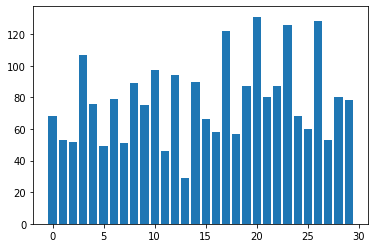

In [8]:
a,b=zip(*sorted(Counter(y_train).items(),key=lambda x:x[0]))
plt.bar(a,b)

In [9]:
from collections import Counter
counter=Counter(y_train)
weights=np.array([1/counter[val] for val in y_train])
weights/=weights.sum()
idxs=np.random.choice(range(len(y_train)),len(y_train),p=weights)

<BarContainer object of 30 artists>

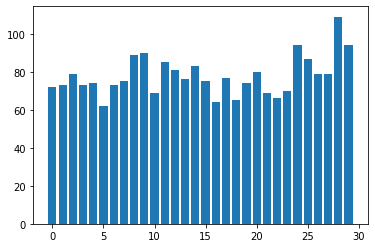

In [10]:
a,b=zip(*sorted(Counter(y_train[idxs]).items(),key=lambda x:x[0]))
plt.bar(a,b)

In [11]:
def gen(X,y,augment,balanced):
    n=len(X)
    
    if balanced:
        counter=Counter(y)
        weights=np.array([1/counter[val] for val in y])
        weights/=weights.sum()
        idxs=np.random.choice(range(n),n,p=weights)
    else:
        idxs=list(range(n))
        
    offsets=np.random.randint(12,size=n)
    np.random.shuffle(idxs)
    
    l=list(range(12))
    
    ls=[]
    for i in range(12):
        ls.append(l[i:]+l[:i])
    
    for idx,i in zip(idxs,offsets):
        if augment:
            yield X[idx].take(ls[i],axis=0),y[idx]
        else:
            yield X[idx],y[idx]




In [12]:
BATCH_SIZE=32
AUGMENT=True
BALANCED=True
train_data=tf.data.Dataset.from_generator(generator=gen,args=(X_train,y_train,AUGMENT,BALANCED),
                                           output_shapes=(tf.TensorShape([12,1500]),tf.TensorShape([])),
                                           output_types=(tf.float32,tf.int8)
                                          ).repeat().batch(BATCH_SIZE)
val_data=tf.data.Dataset.from_tensor_slices((X_val,y_val)).shuffle(1000).batch(BATCH_SIZE)

In [13]:
from tensorflow.keras.layers import Conv2D
from utils import MySequential, ConfusionMatrixMetric, PeriodicPaddingConv2D

In [14]:
ConvLayer=Conv2D

In [15]:
class ConvBlock(keras.layers.Layer):
    
    def __init__(self,*args,**kwargs):
        name=kwargs.pop('name',None)
        super().__init__(name=name)
        self.max_pool=kwargs.pop('max_pool',None)
        self.dropout=kwargs.pop('dropout',None)
        self.zero_padding=kwargs.pop('zero_padding',None)
        self.args=args
        self.kwargs=kwargs
        
        
    def build(self,input_shape):
        layers=[tf.keras.layers.Input(shape=input_shape[1:])]
        if self.zero_padding is not None:
            layers.append(tf.keras.layers.ZeroPadding2D(padding=self.zero_padding))
        layers.extend([
            ConvLayer(*self.args,**self.kwargs),
            keras.layers.LeakyReLU(alpha=leaky_relu_parameter),
            keras.layers.BatchNormalization(axis=[3]), # batch normalization on everything but last dimension
        ])
        if self.max_pool is not None:
            layers.append(keras.layers.MaxPool2D(self.max_pool))
        if self.dropout is not None:
            layers.append(keras.layers.Dropout(self.dropout))
        self.model=keras.Sequential(layers)
        
    def call(self,x):
        return self.model(x)

In [16]:
from tensorflow.keras import Sequential

In [17]:
120/1500*15

1.2

In [23]:
2**5

32

In [35]:
initial_time_only_conv=tf.keras.Sequential([],name='wavenet')

for rate in list(range(5)):
    initial_time_only_conv.add(keras.layers.Conv2D(10,(1,2),padding='valid',dilation_rate=2**rate))
initial_time_only_conv.add(Conv2D(1,(1,1),padding='same'))
model=MySequential([
    keras.layers.Input(shape=(12,1500)),
    keras.layers.Lambda(lambda x: tf.expand_dims(x,-1),name='expand_dims'),
    keras.layers.BatchNormalization(axis=[3],name='norm0'),
    #
    initial_time_only_conv
]).summary()

Model: "my_sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
expand_dims (Lambda)         (None, 12, 1500, 1)       0         
_________________________________________________________________
norm0 (BatchNormalization)   (None, 12, 1500, 1)       4         
_________________________________________________________________
wavenet (Sequential)         (None, 12, 1469, 1)       881       
Total params: 885
Trainable params: 883
Non-trainable params: 2
_________________________________________________________________


In [36]:
dropout_prob=0.3
PADDING_TYPE='valid'
kernel_initializer='he_uniform'
leaky_relu_parameter=1e-2

model=MySequential([
    keras.layers.Input(shape=(12,1500)),
    keras.layers.Lambda(lambda x: tf.expand_dims(x,-1),name='expand_dims'),
    keras.layers.BatchNormalization(axis=[3],name='norm0'),
    #
    initial_time_only_conv,
    #
    ConvBlock(32,(3,3),
              name='conv_block_1',
              zero_padding=(0,1),
              padding=PADDING_TYPE,
              kernel_initializer=kernel_initializer,
              max_pool=(1,2),
              dropout=dropout_prob,
             ),
    ConvBlock(64,(3,3),
              name='conv_block_2',
              zero_padding=(0,1),
              padding=PADDING_TYPE,
              kernel_initializer=kernel_initializer,
              max_pool=(1,3),
              dropout=dropout_prob,
             ),
    ConvBlock(75,(3,3),
              name='conv_block_3',
              zero_padding=(0,1),
              padding=PADDING_TYPE,
              kernel_initializer=kernel_initializer,
              max_pool=(1,2),
              dropout=dropout_prob,
             ),
    ConvBlock(100,(3,3),
              name='conv_block_4',
              padding='same',
              kernel_initializer=kernel_initializer,
             ),
    keras.layers.GlobalAveragePooling2D(name='gba'),
    keras.layers.Dropout(dropout_prob,name='drop4'),
    #
    keras.layers.Dense(30,name='fc',kernel_initializer=kernel_initializer)

])

model.summary()

Model: "my_sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
expand_dims (Lambda)         (None, 12, 1500, 1)       0         
_________________________________________________________________
norm0 (BatchNormalization)   (None, 12, 1500, 1)       4         
_________________________________________________________________
wavenet (Sequential)         (None, 12, 1469, 1)       881       
_________________________________________________________________
conv_block_1 (ConvBlock)     (None, 10, 734, 32)       448       
_________________________________________________________________
conv_block_2 (ConvBlock)     (None, 8, 244, 64)        18752     
_________________________________________________________________
conv_block_3 (ConvBlock)     (None, 6, 122, 75)        43575     
_________________________________________________________________
conv_block_4 (ConvBlock)     (None, 6, 122, 100)   

In [37]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy',ConfusionMatrixMetric(30)])

In [38]:
history=model.fit(train_data,validation_data=val_data,epochs=100,steps_per_epoch=len(X_train)//BATCH_SIZE,verbose=1)

Epoch 1/100
73/73 [==============================] - 10s 137ms/step - loss: 3.3697 - accuracy: 0.0702 - F1_0: 0.0908 - F1_1: 0.0000e+00 - F1_2: 0.0612 - F1_3: 0.0483 - F1_4: 0.0180 - F1_5: 0.0875 - F1_6: 0.0257 - F1_7: 0.0479 - F1_8: 0.0051 - F1_9: 0.0015 - F1_10: 0.0814 - F1_11: 0.0243 - F1_12: 0.0000e+00 - F1_13: 0.1228 - F1_14: 0.0324 - F1_15: 0.0389 - F1_16: 0.0268 - F1_17: 0.0639 - F1_18: 0.0267 - F1_19: 0.0427 - F1_20: 0.0332 - F1_21: 0.1178 - F1_22: 0.0128 - F1_23: 0.0958 - F1_24: 0.0270 - F1_25: 0.0720 - F1_26: 0.1010 - F1_27: 0.0571 - F1_28: 0.0244 - F1_29: 0.0179 - val_loss: 3.8981 - val_accuracy: 0.0212 - val_F1_0: 0.0000e+00 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0000e+00 - val_F1_3: 0.0000e+00 - val_F1_4: 0.0000e+00 - val_F1_5: 0.0000e+00 - val_F1_6: 0.0000e+00 - val_F1_7: 0.0000e+00 - val_F1_8: 0.0000e+00 - val_F1_9: 0.0000e+00 - val_F1_10: 0.0000e+00 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0000e+00 - val_F1_14: 0.0000e+00 - val_F1_15: 0.0000e+00 - va

73/73 [==============================] - 9s 126ms/step - loss: 2.3902 - accuracy: 0.3005 - F1_0: 0.2535 - F1_1: 0.1863 - F1_2: 0.1834 - F1_3: 0.1329 - F1_4: 0.3340 - F1_5: 0.3253 - F1_6: 0.3642 - F1_7: 0.1686 - F1_8: 0.3230 - F1_9: 0.3356 - F1_10: 0.2989 - F1_11: 0.3374 - F1_12: 0.0000e+00 - F1_13: 0.4533 - F1_14: 0.2077 - F1_15: 0.4545 - F1_16: 0.1673 - F1_17: 0.2224 - F1_18: 0.4182 - F1_19: 0.3450 - F1_20: 0.3207 - F1_21: 0.3191 - F1_22: 0.2103 - F1_23: 0.0474 - F1_24: 0.3073 - F1_25: 0.1783 - F1_26: 0.3150 - F1_27: 0.2692 - F1_28: 0.1595 - F1_29: 0.0557 - val_loss: 2.9681 - val_accuracy: 0.1681 - val_F1_0: 0.0000e+00 - val_F1_1: 0.3404 - val_F1_2: 0.2273 - val_F1_3: 0.0909 - val_F1_4: 0.0930 - val_F1_5: 0.0000e+00 - val_F1_6: 0.1277 - val_F1_7: 0.2727 - val_F1_8: 0.2222 - val_F1_9: 0.0000e+00 - val_F1_10: 0.2642 - val_F1_11: 0.0000e+00 - val_F1_12: 0.1379 - val_F1_13: 0.0377 - val_F1_14: 0.1364 - val_F1_15: 0.1259 - val_F1_16: 0.0909 - val_F1_17: 0.0000e+00 - val_F1_18: 0.5091 - val

Epoch 14/100
73/73 [==============================] - 9s 126ms/step - loss: 1.8186 - accuracy: 0.4658 - F1_0: 0.5049 - F1_1: 0.3484 - F1_2: 0.5203 - F1_3: 0.4622 - F1_4: 0.6953 - F1_5: 0.4040 - F1_6: 0.6215 - F1_7: 0.4970 - F1_8: 0.5638 - F1_9: 0.5036 - F1_10: 0.4546 - F1_11: 0.3989 - F1_12: 0.0970 - F1_13: 0.5203 - F1_14: 0.4730 - F1_15: 0.5578 - F1_16: 0.4360 - F1_17: 0.4281 - F1_18: 0.5942 - F1_19: 0.5257 - F1_20: 0.4963 - F1_21: 0.5401 - F1_22: 0.2927 - F1_23: 0.3774 - F1_24: 0.2666 - F1_25: 0.5634 - F1_26: 0.5253 - F1_27: 0.1971 - F1_28: 0.4735 - F1_29: 0.4153 - val_loss: 3.6159 - val_accuracy: 0.2005 - val_F1_0: 0.0000e+00 - val_F1_1: 0.1053 - val_F1_2: 0.0678 - val_F1_3: 0.2051 - val_F1_4: 0.1538 - val_F1_5: 0.1379 - val_F1_6: 0.2500 - val_F1_7: 0.3438 - val_F1_8: 0.3721 - val_F1_9: 0.4348 - val_F1_10: 0.0000e+00 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0741 - val_F1_14: 0.1455 - val_F1_15: 0.0741 - val_F1_16: 0.1188 - val_F1_17: 0.0000e+00 - val_F1_18: 0.3

Epoch 21/100
73/73 [==============================] - 9s 127ms/step - loss: 1.4587 - accuracy: 0.5625 - F1_0: 0.6394 - F1_1: 0.3759 - F1_2: 0.5101 - F1_3: 0.4935 - F1_4: 0.8093 - F1_5: 0.6589 - F1_6: 0.6866 - F1_7: 0.4515 - F1_8: 0.5739 - F1_9: 0.6781 - F1_10: 0.3436 - F1_11: 0.2637 - F1_12: 0.3577 - F1_13: 0.5790 - F1_14: 0.5774 - F1_15: 0.5962 - F1_16: 0.5369 - F1_17: 0.3664 - F1_18: 0.6786 - F1_19: 0.6539 - F1_20: 0.6664 - F1_21: 0.7382 - F1_22: 0.7089 - F1_23: 0.4147 - F1_24: 0.5326 - F1_25: 0.5064 - F1_26: 0.4690 - F1_27: 0.3591 - F1_28: 0.3187 - F1_29: 0.6060 - val_loss: 2.4319 - val_accuracy: 0.3263 - val_F1_0: 0.2812 - val_F1_1: 0.3750 - val_F1_2: 0.0714 - val_F1_3: 0.3659 - val_F1_4: 0.3429 - val_F1_5: 0.4615 - val_F1_6: 0.5455 - val_F1_7: 0.3820 - val_F1_8: 0.6087 - val_F1_9: 0.4103 - val_F1_10: 0.1356 - val_F1_11: 0.0909 - val_F1_12: 0.0000e+00 - val_F1_13: 0.2353 - val_F1_14: 0.2703 - val_F1_15: 0.1493 - val_F1_16: 0.1111 - val_F1_17: 0.1463 - val_F1_18: 0.5000 - val_F1_19:

Epoch 28/100
73/73 [==============================] - 9s 127ms/step - loss: 1.2583 - accuracy: 0.6353 - F1_0: 0.6298 - F1_1: 0.5847 - F1_2: 0.6267 - F1_3: 0.5836 - F1_4: 0.7812 - F1_5: 0.6607 - F1_6: 0.8058 - F1_7: 0.6733 - F1_8: 0.6879 - F1_9: 0.6900 - F1_10: 0.6216 - F1_11: 0.5748 - F1_12: 0.3427 - F1_13: 0.6312 - F1_14: 0.7004 - F1_15: 0.7867 - F1_16: 0.5238 - F1_17: 0.3405 - F1_18: 0.7574 - F1_19: 0.5947 - F1_20: 0.7083 - F1_21: 0.6218 - F1_22: 0.7135 - F1_23: 0.4250 - F1_24: 0.6175 - F1_25: 0.5068 - F1_26: 0.6299 - F1_27: 0.4820 - F1_28: 0.4017 - F1_29: 0.5507 - val_loss: 2.3561 - val_accuracy: 0.3263 - val_F1_0: 0.1364 - val_F1_1: 0.4082 - val_F1_2: 0.0652 - val_F1_3: 0.4615 - val_F1_4: 0.2000 - val_F1_5: 0.7097 - val_F1_6: 0.4375 - val_F1_7: 0.5421 - val_F1_8: 0.4776 - val_F1_9: 0.5581 - val_F1_10: 0.0784 - val_F1_11: 0.0690 - val_F1_12: 0.0000e+00 - val_F1_13: 0.3077 - val_F1_14: 0.4308 - val_F1_15: 0.0667 - val_F1_16: 0.1241 - val_F1_17: 0.0870 - val_F1_18: 0.6061 - val_F1_19:

Epoch 35/100
73/73 [==============================] - 9s 127ms/step - loss: 1.1187 - accuracy: 0.6699 - F1_0: 0.8519 - F1_1: 0.4530 - F1_2: 0.6494 - F1_3: 0.7498 - F1_4: 0.8078 - F1_5: 0.7169 - F1_6: 0.7899 - F1_7: 0.6076 - F1_8: 0.5819 - F1_9: 0.7218 - F1_10: 0.6749 - F1_11: 0.5534 - F1_12: 0.5439 - F1_13: 0.7483 - F1_14: 0.7461 - F1_15: 0.6819 - F1_16: 0.6040 - F1_17: 0.6000 - F1_18: 0.7943 - F1_19: 0.6649 - F1_20: 0.7139 - F1_21: 0.7946 - F1_22: 0.7078 - F1_23: 0.5364 - F1_24: 0.7967 - F1_25: 0.7007 - F1_26: 0.7021 - F1_27: 0.4959 - F1_28: 0.6260 - F1_29: 0.5342 - val_loss: 2.2513 - val_accuracy: 0.3910 - val_F1_0: 0.2927 - val_F1_1: 0.2308 - val_F1_2: 0.0952 - val_F1_3: 0.3529 - val_F1_4: 0.3529 - val_F1_5: 0.4524 - val_F1_6: 0.3721 - val_F1_7: 0.3894 - val_F1_8: 0.6154 - val_F1_9: 0.5306 - val_F1_10: 0.4127 - val_F1_11: 0.1875 - val_F1_12: 0.1538 - val_F1_13: 0.4565 - val_F1_14: 0.4848 - val_F1_15: 0.1860 - val_F1_16: 0.2400 - val_F1_17: 0.2963 - val_F1_18: 0.5714 - val_F1_19: 0.6

Epoch 42/100
73/73 [==============================] - 9s 127ms/step - loss: 0.9678 - accuracy: 0.7072 - F1_0: 0.6990 - F1_1: 0.6624 - F1_2: 0.6053 - F1_3: 0.6695 - F1_4: 0.8301 - F1_5: 0.6858 - F1_6: 0.7687 - F1_7: 0.7672 - F1_8: 0.7472 - F1_9: 0.7132 - F1_10: 0.7878 - F1_11: 0.6285 - F1_12: 0.5574 - F1_13: 0.6966 - F1_14: 0.8037 - F1_15: 0.7212 - F1_16: 0.7515 - F1_17: 0.5704 - F1_18: 0.7781 - F1_19: 0.6982 - F1_20: 0.5283 - F1_21: 0.7500 - F1_22: 0.7606 - F1_23: 0.5667 - F1_24: 0.6815 - F1_25: 0.8609 - F1_26: 0.6851 - F1_27: 0.6395 - F1_28: 0.5780 - F1_29: 0.6796 - val_loss: 2.1667 - val_accuracy: 0.3910 - val_F1_0: 0.3704 - val_F1_1: 0.3600 - val_F1_2: 0.0889 - val_F1_3: 0.4545 - val_F1_4: 0.7407 - val_F1_5: 0.4490 - val_F1_6: 0.4444 - val_F1_7: 0.5524 - val_F1_8: 0.5417 - val_F1_9: 0.5581 - val_F1_10: 0.3333 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0606 - val_F1_13: 0.4348 - val_F1_14: 0.4000 - val_F1_15: 0.1333 - val_F1_16: 0.1964 - val_F1_17: 0.1538 - val_F1_18: 0.6061 - val_F1_19:

Epoch 49/100
73/73 [==============================] - 9s 127ms/step - loss: 0.8719 - accuracy: 0.7380 - F1_0: 0.7686 - F1_1: 0.6830 - F1_2: 0.6507 - F1_3: 0.7161 - F1_4: 0.8222 - F1_5: 0.7904 - F1_6: 0.8350 - F1_7: 0.6577 - F1_8: 0.7411 - F1_9: 0.7598 - F1_10: 0.7077 - F1_11: 0.6853 - F1_12: 0.5242 - F1_13: 0.8908 - F1_14: 0.6950 - F1_15: 0.7849 - F1_16: 0.7903 - F1_17: 0.6444 - F1_18: 0.8567 - F1_19: 0.7743 - F1_20: 0.7810 - F1_21: 0.6845 - F1_22: 0.8112 - F1_23: 0.6251 - F1_24: 0.7698 - F1_25: 0.7112 - F1_26: 0.8059 - F1_27: 0.6207 - F1_28: 0.7544 - F1_29: 0.5660 - val_loss: 2.4600 - val_accuracy: 0.3587 - val_F1_0: 0.1053 - val_F1_1: 0.2545 - val_F1_2: 0.2222 - val_F1_3: 0.3333 - val_F1_4: 0.3810 - val_F1_5: 0.6667 - val_F1_6: 0.1750 - val_F1_7: 0.4404 - val_F1_8: 0.4483 - val_F1_9: 0.4091 - val_F1_10: 0.4127 - val_F1_11: 0.0000e+00 - val_F1_12: 0.3200 - val_F1_13: 0.4103 - val_F1_14: 0.4737 - val_F1_15: 0.4444 - val_F1_16: 0.1951 - val_F1_17: 0.1053 - val_F1_18: 0.1600 - val_F1_19:

Epoch 56/100
73/73 [==============================] - 9s 127ms/step - loss: 0.8249 - accuracy: 0.7530 - F1_0: 0.8405 - F1_1: 0.8109 - F1_2: 0.7639 - F1_3: 0.8487 - F1_4: 0.8647 - F1_5: 0.7848 - F1_6: 0.8100 - F1_7: 0.7502 - F1_8: 0.8579 - F1_9: 0.7481 - F1_10: 0.7058 - F1_11: 0.6901 - F1_12: 0.6348 - F1_13: 0.8392 - F1_14: 0.7326 - F1_15: 0.8246 - F1_16: 0.7954 - F1_17: 0.6018 - F1_18: 0.8343 - F1_19: 0.7788 - F1_20: 0.6694 - F1_21: 0.7761 - F1_22: 0.7895 - F1_23: 0.6377 - F1_24: 0.7501 - F1_25: 0.7246 - F1_26: 0.6002 - F1_27: 0.6822 - F1_28: 0.7620 - F1_29: 0.6515 - val_loss: 2.2522 - val_accuracy: 0.4035 - val_F1_0: 0.3077 - val_F1_1: 0.2791 - val_F1_2: 0.0435 - val_F1_3: 0.2791 - val_F1_4: 0.7778 - val_F1_5: 0.6667 - val_F1_6: 0.3913 - val_F1_7: 0.3396 - val_F1_8: 0.3810 - val_F1_9: 0.2105 - val_F1_10: 0.4762 - val_F1_11: 0.2222 - val_F1_12: 0.4571 - val_F1_13: 0.5091 - val_F1_14: 0.4330 - val_F1_15: 0.1667 - val_F1_16: 0.3860 - val_F1_17: 0.3333 - val_F1_18: 0.6111 - val_F1_19: 0.6

Epoch 63/100
73/73 [==============================] - 9s 127ms/step - loss: 0.7683 - accuracy: 0.7594 - F1_0: 0.7752 - F1_1: 0.6611 - F1_2: 0.5722 - F1_3: 0.7006 - F1_4: 0.8668 - F1_5: 0.8188 - F1_6: 0.7295 - F1_7: 0.7436 - F1_8: 0.6790 - F1_9: 0.7682 - F1_10: 0.7582 - F1_11: 0.6853 - F1_12: 0.7357 - F1_13: 0.7138 - F1_14: 0.8330 - F1_15: 0.8366 - F1_16: 0.7859 - F1_17: 0.6592 - F1_18: 0.8306 - F1_19: 0.7701 - F1_20: 0.8156 - F1_21: 0.7483 - F1_22: 0.8256 - F1_23: 0.6835 - F1_24: 0.7944 - F1_25: 0.6806 - F1_26: 0.5918 - F1_27: 0.7252 - F1_28: 0.6134 - F1_29: 0.7718 - val_loss: 2.2659 - val_accuracy: 0.4446 - val_F1_0: 0.4255 - val_F1_1: 0.3934 - val_F1_2: 0.2800 - val_F1_3: 0.4375 - val_F1_4: 0.4118 - val_F1_5: 0.6765 - val_F1_6: 0.3529 - val_F1_7: 0.4667 - val_F1_8: 0.6522 - val_F1_9: 0.4889 - val_F1_10: 0.3636 - val_F1_11: 0.3333 - val_F1_12: 0.4516 - val_F1_13: 0.4250 - val_F1_14: 0.4138 - val_F1_15: 0.4062 - val_F1_16: 0.3571 - val_F1_17: 0.3478 - val_F1_18: 0.6471 - val_F1_19: 0.6

Epoch 70/100
73/73 [==============================] - 9s 124ms/step - loss: 0.6595 - accuracy: 0.7992 - F1_0: 0.8860 - F1_1: 0.6745 - F1_2: 0.6998 - F1_3: 0.8122 - F1_4: 0.8166 - F1_5: 0.8274 - F1_6: 0.7701 - F1_7: 0.8649 - F1_8: 0.8387 - F1_9: 0.8892 - F1_10: 0.7521 - F1_11: 0.6714 - F1_12: 0.7340 - F1_13: 0.8451 - F1_14: 0.8166 - F1_15: 0.8566 - F1_16: 0.6176 - F1_17: 0.6569 - F1_18: 0.8396 - F1_19: 0.8481 - F1_20: 0.8195 - F1_21: 0.8671 - F1_22: 0.7720 - F1_23: 0.6533 - F1_24: 0.7859 - F1_25: 0.8653 - F1_26: 0.6662 - F1_27: 0.7737 - F1_28: 0.7074 - F1_29: 0.6619 - val_loss: 2.1939 - val_accuracy: 0.4682 - val_F1_0: 0.4839 - val_F1_1: 0.4138 - val_F1_2: 0.2308 - val_F1_3: 0.3529 - val_F1_4: 0.4800 - val_F1_5: 0.5085 - val_F1_6: 0.3721 - val_F1_7: 0.3871 - val_F1_8: 0.4706 - val_F1_9: 0.6522 - val_F1_10: 0.4545 - val_F1_11: 0.4375 - val_F1_12: 0.6667 - val_F1_13: 0.4200 - val_F1_14: 0.2581 - val_F1_15: 0.5306 - val_F1_16: 0.4571 - val_F1_17: 0.4667 - val_F1_18: 0.5882 - val_F1_19: 0.6

Epoch 77/100
73/73 [==============================] - 9s 123ms/step - loss: 0.6456 - accuracy: 0.8091 - F1_0: 0.8635 - F1_1: 0.7546 - F1_2: 0.6817 - F1_3: 0.7489 - F1_4: 0.8897 - F1_5: 0.8875 - F1_6: 0.8010 - F1_7: 0.7634 - F1_8: 0.8201 - F1_9: 0.8674 - F1_10: 0.6752 - F1_11: 0.7281 - F1_12: 0.7847 - F1_13: 0.8698 - F1_14: 0.8770 - F1_15: 0.8433 - F1_16: 0.8417 - F1_17: 0.6833 - F1_18: 0.8717 - F1_19: 0.8638 - F1_20: 0.7858 - F1_21: 0.8140 - F1_22: 0.8216 - F1_23: 0.6059 - F1_24: 0.8440 - F1_25: 0.7901 - F1_26: 0.8188 - F1_27: 0.7099 - F1_28: 0.7373 - F1_29: 0.8249 - val_loss: 2.2209 - val_accuracy: 0.4471 - val_F1_0: 0.1765 - val_F1_1: 0.2963 - val_F1_2: 0.2903 - val_F1_3: 0.2759 - val_F1_4: 0.5714 - val_F1_5: 0.4348 - val_F1_6: 0.3000 - val_F1_7: 0.3878 - val_F1_8: 0.6667 - val_F1_9: 0.5581 - val_F1_10: 0.5143 - val_F1_11: 0.2642 - val_F1_12: 0.5854 - val_F1_13: 0.4752 - val_F1_14: 0.3908 - val_F1_15: 0.5455 - val_F1_16: 0.4444 - val_F1_17: 0.5161 - val_F1_18: 0.6111 - val_F1_19: 0.5

Epoch 84/100
73/73 [==============================] - 9s 124ms/step - loss: 0.5770 - accuracy: 0.8176 - F1_0: 0.8084 - F1_1: 0.7806 - F1_2: 0.8676 - F1_3: 0.8520 - F1_4: 0.8645 - F1_5: 0.8822 - F1_6: 0.9276 - F1_7: 0.8273 - F1_8: 0.8354 - F1_9: 0.8704 - F1_10: 0.7570 - F1_11: 0.6715 - F1_12: 0.7605 - F1_13: 0.8694 - F1_14: 0.8443 - F1_15: 0.8494 - F1_16: 0.8396 - F1_17: 0.7089 - F1_18: 0.8697 - F1_19: 0.7756 - F1_20: 0.8212 - F1_21: 0.8120 - F1_22: 0.9201 - F1_23: 0.7274 - F1_24: 0.7565 - F1_25: 0.8887 - F1_26: 0.8001 - F1_27: 0.7866 - F1_28: 0.8087 - F1_29: 0.8021 - val_loss: 2.1921 - val_accuracy: 0.4583 - val_F1_0: 0.5000 - val_F1_1: 0.5152 - val_F1_2: 0.2800 - val_F1_3: 0.5660 - val_F1_4: 0.6667 - val_F1_5: 0.5846 - val_F1_6: 0.4615 - val_F1_7: 0.3778 - val_F1_8: 0.5000 - val_F1_9: 0.5484 - val_F1_10: 0.2222 - val_F1_11: 0.4800 - val_F1_12: 0.5854 - val_F1_13: 0.3030 - val_F1_14: 0.4923 - val_F1_15: 0.6667 - val_F1_16: 0.5366 - val_F1_17: 0.4286 - val_F1_18: 0.6667 - val_F1_19: 0.7

Epoch 91/100
73/73 [==============================] - 9s 124ms/step - loss: 0.5518 - accuracy: 0.8373 - F1_0: 0.8527 - F1_1: 0.7963 - F1_2: 0.7272 - F1_3: 0.8507 - F1_4: 0.9321 - F1_5: 0.8676 - F1_6: 0.8600 - F1_7: 0.8226 - F1_8: 0.9320 - F1_9: 0.7889 - F1_10: 0.8750 - F1_11: 0.7929 - F1_12: 0.7187 - F1_13: 0.9155 - F1_14: 0.8385 - F1_15: 0.9244 - F1_16: 0.7841 - F1_17: 0.8206 - F1_18: 0.8062 - F1_19: 0.9245 - F1_20: 0.8919 - F1_21: 0.8157 - F1_22: 0.8157 - F1_23: 0.7551 - F1_24: 0.9116 - F1_25: 0.8663 - F1_26: 0.7868 - F1_27: 0.8309 - F1_28: 0.8198 - F1_29: 0.8040 - val_loss: 2.4390 - val_accuracy: 0.4359 - val_F1_0: 0.5000 - val_F1_1: 0.1429 - val_F1_2: 0.2353 - val_F1_3: 0.2143 - val_F1_4: 0.6316 - val_F1_5: 0.4800 - val_F1_6: 0.3636 - val_F1_7: 0.3725 - val_F1_8: 0.5366 - val_F1_9: 0.5455 - val_F1_10: 0.5400 - val_F1_11: 0.3750 - val_F1_12: 0.5000 - val_F1_13: 0.5000 - val_F1_14: 0.2041 - val_F1_15: 0.5484 - val_F1_16: 0.6667 - val_F1_17: 0.5556 - val_F1_18: 0.6939 - val_F1_19: 0.6

Epoch 98/100
73/73 [==============================] - 9s 124ms/step - loss: 0.5471 - accuracy: 0.8373 - F1_0: 0.8509 - F1_1: 0.8080 - F1_2: 0.7437 - F1_3: 0.7986 - F1_4: 0.9133 - F1_5: 0.8134 - F1_6: 0.8489 - F1_7: 0.8306 - F1_8: 0.8317 - F1_9: 0.8117 - F1_10: 0.9012 - F1_11: 0.8327 - F1_12: 0.9083 - F1_13: 0.9200 - F1_14: 0.8221 - F1_15: 0.8879 - F1_16: 0.8520 - F1_17: 0.8861 - F1_18: 0.8908 - F1_19: 0.8314 - F1_20: 0.8667 - F1_21: 0.8310 - F1_22: 0.8235 - F1_23: 0.7708 - F1_24: 0.8545 - F1_25: 0.8073 - F1_26: 0.7802 - F1_27: 0.8686 - F1_28: 0.7387 - F1_29: 0.6024 - val_loss: 2.1111 - val_accuracy: 0.4832 - val_F1_0: 0.5862 - val_F1_1: 0.5135 - val_F1_2: 0.1538 - val_F1_3: 0.5000 - val_F1_4: 0.7778 - val_F1_5: 0.5714 - val_F1_6: 0.4571 - val_F1_7: 0.4275 - val_F1_8: 0.6667 - val_F1_9: 0.6667 - val_F1_10: 0.5000 - val_F1_11: 0.2439 - val_F1_12: 0.5161 - val_F1_13: 0.4533 - val_F1_14: 0.4667 - val_F1_15: 0.5217 - val_F1_16: 0.3509 - val_F1_17: 0.6061 - val_F1_18: 0.7222 - val_F1_19: 0.7

In [39]:
TRAINING_HISTORY_FOLDER='training_history'
os.makedirs(TRAINING_HISTORY_FOLDER,exist_ok=True)
TRAINING_HISTORY_FILENAME = 'tmp3.json'

training_history_file=os.path.join(TRAINING_HISTORY_FOLDER,TRAINING_HISTORY_FILENAME)

In [40]:
#model.save_weights('phase_1_weights_100_epochs')

In [41]:
json.dump(history.history,open(training_history_file,'w'),indent=2)

In [42]:
training_history_file

'training_history/tmp3.json'

In [43]:
history_dict_unaugmented=json.load(open(os.path.join(TRAINING_HISTORY_FOLDER,'unaugmented.json')))
history_dict_augmented=json.load(open(os.path.join(TRAINING_HISTORY_FOLDER,'augmented.json')))
history_dict=json.load(open(training_history_file))

In [44]:
ragas_idx={'Abhogi': 0, 'Ahir bhairav': 1, 'Alahiya bilawal': 2, 'Bageshree': 3, 'Bairagi': 4, 'Basant': 5, 'Bhairav': 6, 'Bhoop': 7, 'Bihag': 8, 'Bilaskhani todi': 9, 'Darbari': 10, 'Des': 11, 'Gaud malhar': 12, 'Hamsadhvani': 13, 'Jog': 14, 'Kedar': 15, 'Khamaj': 16, 'Lalat': 17, 'Madhukauns': 18, 'Madhuvanti': 19, 'Malkauns': 20, 'Marubihag': 21, 'Marwa': 22, 'Miya malhar': 23, 'Puriya dhanashree': 24, 'Rageshri': 25, 'Shree': 26, 'Shuddh sarang': 27, 'Todi': 28, 'Yaman kalyan': 29}

In [45]:
ragas_reverse_idx={v:k for k,v in ragas_idx.items()}

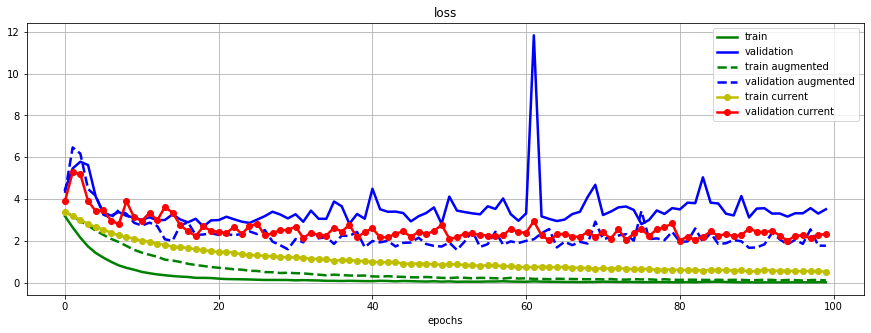

In [46]:
plt.figure(figsize=(15,5))
plt.plot(history_dict_unaugmented['loss'],'g-',label='train')
plt.plot(history_dict_unaugmented['val_loss'],'b-',label='validation')
plt.plot(history_dict_augmented['loss'],'g--',label='train augmented')
plt.plot(history_dict_augmented['val_loss'],'b--',label='validation augmented')
plt.plot(history_dict['loss'],'yo-',label='train current')
plt.plot(history_dict['val_loss'],'ro-',label='validation current')
plt.title('loss')
plt.xlabel('epochs')
plt.legend()
#plt.xticks(range(100),range(1,101))
plt.grid(True)

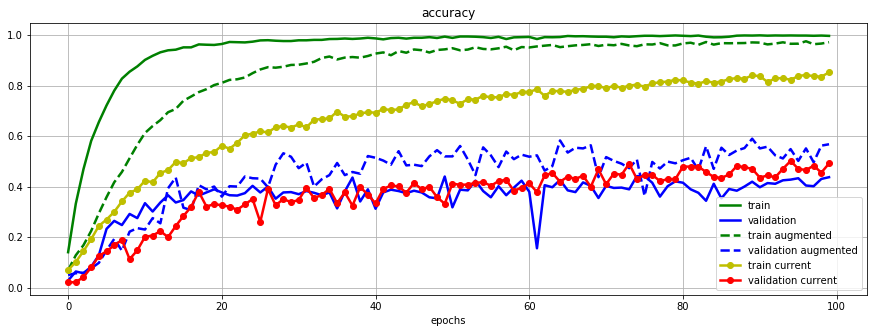

In [47]:
plt.figure(figsize=(15,5))
plt.plot(history_dict_unaugmented['accuracy'],'g-',label='train')
plt.plot(history_dict_unaugmented['val_accuracy'],'b-',label='validation')
plt.plot(history_dict_augmented['accuracy'],'g--',label='train augmented')
plt.plot(history_dict_augmented['val_accuracy'],'b--',label='validation augmented')
plt.plot(history_dict['accuracy'],'yo-',label='train current')
plt.plot(history_dict['val_accuracy'],'ro-',label='validation current')
plt.legend()
plt.xlabel('epochs')
plt.title('accuracy')
#plt.xticks(range(20),range(1,21))
plt.grid(True)

Text(0.5, 1.0, 'Val F1s in the last 20 epochs')

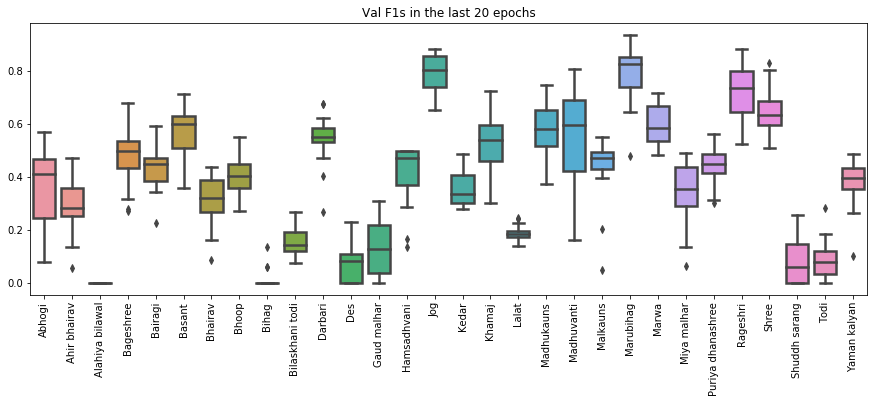

In [48]:
import pandas as pd
import seaborn as sns
fig=plt.figure(figsize=(15,5))
f1s=pd.DataFrame({ragas_reverse_idx[i]:history_dict_unaugmented['val_F1_{}'.format(i)][-20:] for i in range(30)})
ax=sns.boxplot( data=f1s)
ax.get_xticklabels()
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Val F1s in the last 20 epochs')

Text(0.5, 1.0, 'Val F1s in the last 20 epochs')

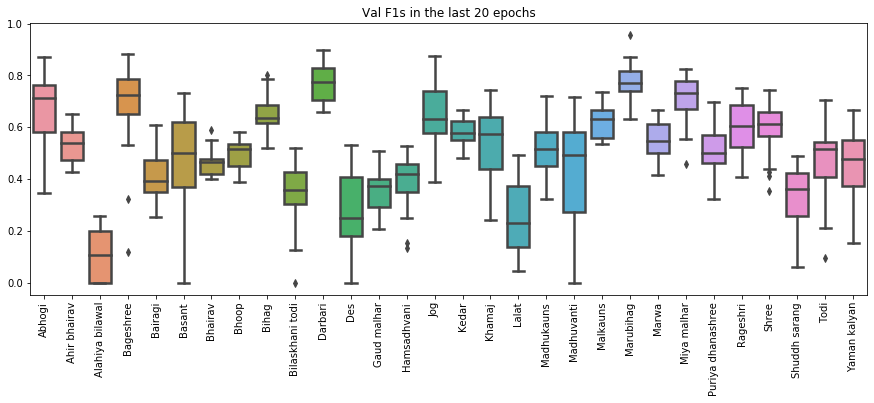

In [49]:
import pandas as pd
import seaborn as sns
fig=plt.figure(figsize=(15,5))
f1s=pd.DataFrame({ragas_reverse_idx[i]:history_dict_augmented['val_F1_{}'.format(i)][-20:] for i in range(30)})
ax=sns.boxplot( data=f1s)
ax.get_xticklabels()
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Val F1s in the last 20 epochs')

Text(0.5, 1.0, 'Val F1s in the last 20 epochs')

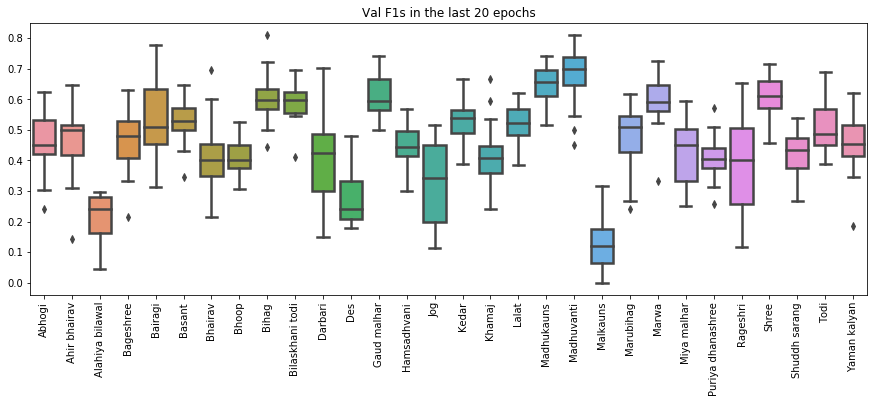

In [50]:
import pandas as pd
import seaborn as sns
fig=plt.figure(figsize=(15,5))
f1s=pd.DataFrame({ragas_reverse_idx[i]:history_dict['val_F1_{}'.format(i)][-20:] for i in range(30)})
ax=sns.boxplot( data=f1s)
ax.get_xticklabels()
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Val F1s in the last 20 epochs')

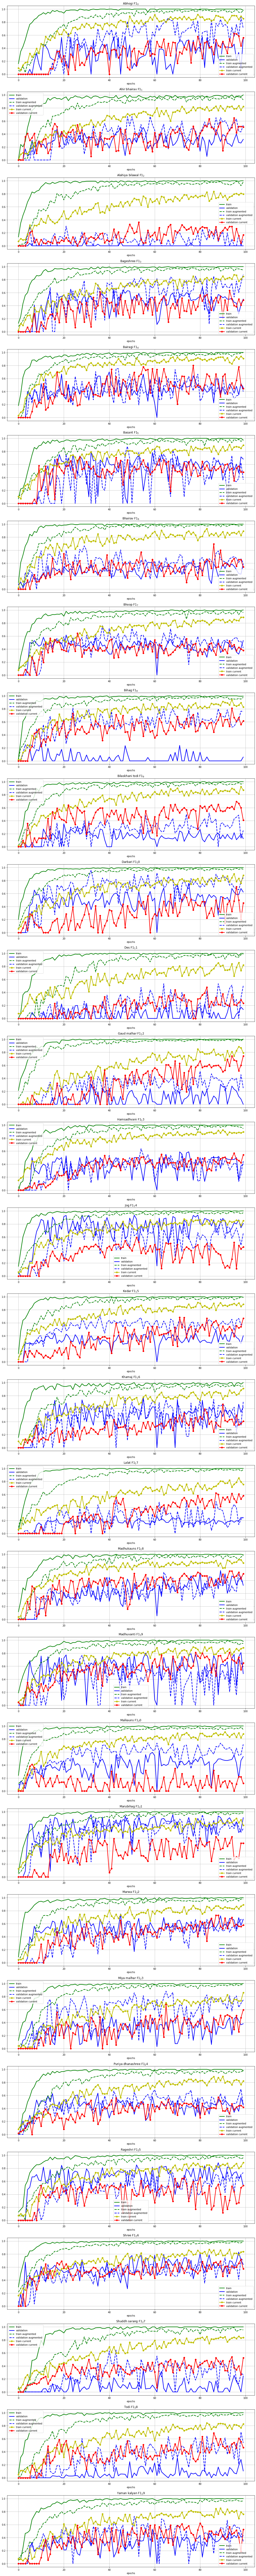

In [51]:
plt.figure(figsize=(15,5*30))
for i in range(30):
    plt.subplot(30,1,i+1)
    plt.plot(history_dict_unaugmented['F1_{}'.format(i)],'g-',label='train')
    plt.plot(history_dict_unaugmented['val_F1_{}'.format(i)],'b-',label='validation')
    plt.plot(history_dict_augmented['F1_{}'.format(i)],'g--',label='train augmented')
    plt.plot(history_dict_augmented['val_F1_{}'.format(i)],'b--',label='validation augmented')
    plt.plot(history_dict['F1_{}'.format(i)],'yo-',label='train current')
    plt.plot(history_dict['val_F1_{}'.format(i)],'ro-',label='validation current')
    plt.title(r'{raga_name} F1$_{raga_id}$'.format(raga_id=i,raga_name=ragas_reverse_idx[i]))
    plt.xlabel('epochs')
    plt.legend()
    plt.grid(True)
plt.tight_layout()

In [52]:
y_pred=np.argmax(model.predict(X_val),axis=-1)
y_true=y_val

In [53]:
cm=tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32,num_classes=30)


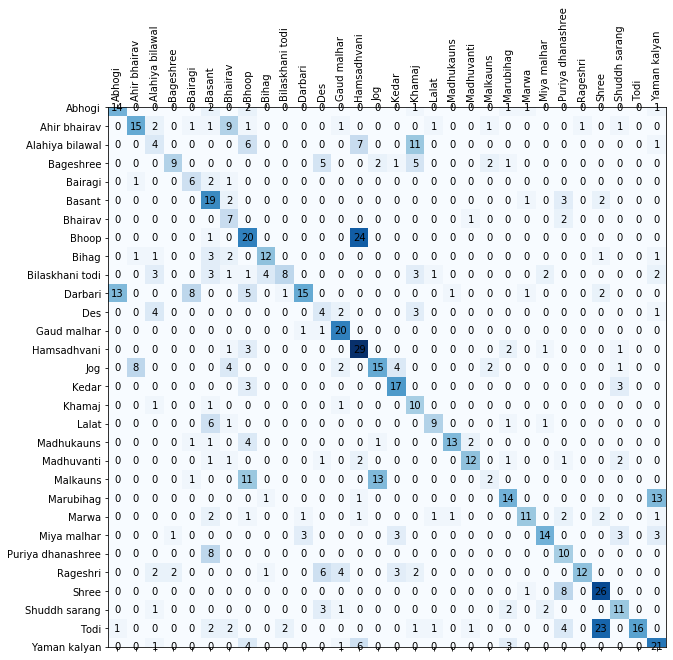

In [54]:
fig, ax = plt.subplots(figsize=(10,10))


cm_matrix = cm.numpy().astype(np.int32)

ax.matshow(cm_matrix, cmap=plt.cm.Blues)

for i in range(30):
    for j in range(30):
        c = cm_matrix[j,i]
        ax.text(i, j, str(c), va='center', ha='center',size=10)
plt.xticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=90)
plt.yticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=0)
plt.show()

In [55]:
def process_confusion_matrix(cm):
    "returns precision, recall and f1 along with overall accuracy"
    diag_part=tf.linalg.diag_part(cm)
    precision=diag_part/(tf.reduce_sum(cm,0)+tf.constant(1e-15))
    recall=diag_part/(tf.reduce_sum(cm,1)+tf.constant(1e-15))
    f1=2*precision*recall/(precision+recall+tf.constant(1e-15))
    return precision,recall,f1

In [56]:
precision,recall,f1=process_confusion_matrix(cm)

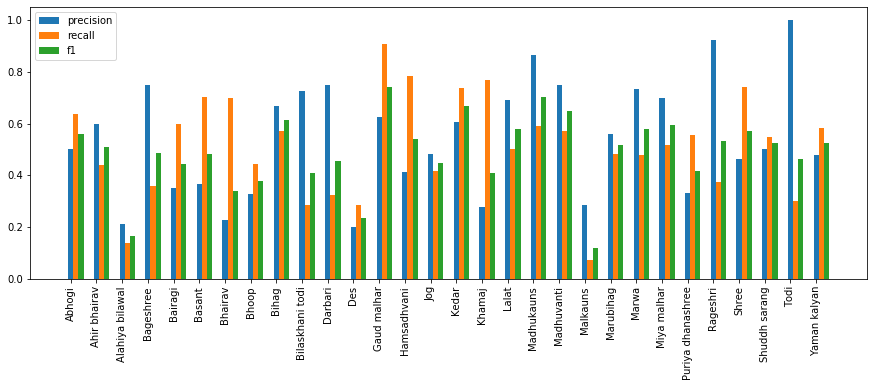

In [57]:
fig=plt.figure(figsize=(15,5))
plt.bar(np.arange(30),precision.numpy(),width=.2,label='precision')
plt.bar(np.arange(30)+.2,recall.numpy(),width=.2,label='recall')
plt.bar(np.arange(30)+.4,f1.numpy(),width=.2,label='f1')
plt.xticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=90)
plt.legend()
plt.show()